In [2]:
import torch
import os

In [3]:
### CNN

cnn_activations_path = "activations_old.pt"

cnn_activations = torch.load(cnn_activations_path)


In [21]:
print(type(cnn_activations))

print(cnn_activations.keys())

a = cnn_activations[9]  ###last epoch

print(type(a))
print(a.keys())

train_activations = a["train"]
print(type(train_activations))
print(train_activations.__len__())

first = train_activations[0]

print(type(first))
print(first.shape)


first = first.detach().cpu()
selected_activations =first

<class 'dict'>
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
<class 'dict'>
dict_keys(['train', 'val'])
<class 'list'>
4
<class 'torch.Tensor'>
torch.Size([512, 25000])


In [33]:
print(selected_activations.shape)

torch.Size([25000, 512])


In [32]:
selected_activations = selected_activations.transpose(0,1)

In [34]:
import umap

reducer = umap.UMAP()

embedding = reducer.fit_transform(selected_activations)


In [38]:

print(embedding.shape[0])
### fake the y
import numpy as np
y = np.ones(embedding.shape[0])
print(y.shape) 

25000
(25000,)


(25000, 2)
(25000,)


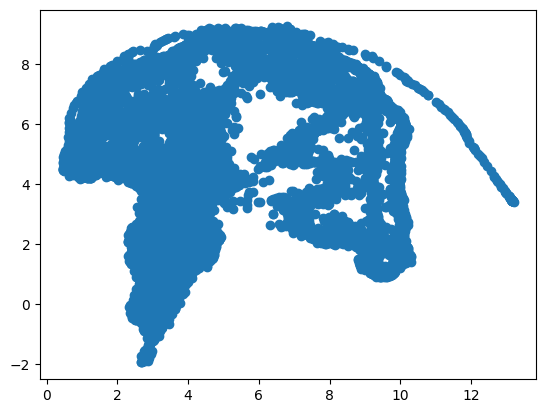

In [41]:
import matplotlib.pyplot as plt

print(embedding.shape)
print(y.shape)

scatter = plt.scatter(embedding[:,0], embedding[:,1])

## Transformer

In [3]:
path = os.path.join("testRunArticles","collector.pt")
collector = torch.load(path)
epoch_1 = collector[0]
print(epoch_1.keys())

trainSplit = epoch_1["train_outputs"]
activations = trainSplit["activations"]
targets = trainSplit["targets"]
preds = trainSplit["preds"]
true_subclasses = trainSplit["true_subclass"]
print(targets.shape)
print(activations.shape)
print(preds.shape)
print(true_subclasses.shape)

dict_keys(['train_outputs', 'val_outputs'])
torch.Size([80640])
torch.Size([80640, 768])
torch.Size([80640])
torch.Size([80640])


In [3]:
print(trainSplit.keys())

dict_keys(['metrics', 'activations', 'superclass', 'subclass', 'true_subclass', 'alt_subclass', 'targets', 'probs', 'preds', 'losses', 'reweight'])


In [4]:
print(trainSplit["true_subclass"].shape)
print(trainSplit["targets"].shape)

torch.Size([80640])
torch.Size([80640])


In [5]:
print(targets.unique())
print(trainSplit["true_subclass"].unique())

tensor([0, 1, 2, 3, 4])
tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])


In [6]:
print(activations.shape)
print(targets.shape)
print(preds.shape)
print(true_subclasses.shape)

torch.Size([80640, 768])
torch.Size([80640])
torch.Size([80640])
torch.Size([80640])


In [32]:
selcted_superclass = 3

In [33]:
selected_activations = activations[targets == selcted_superclass]
selected_subclasses = true_subclasses[targets == selcted_superclass]

In [ ]:
import umap

reducer = umap.UMAP()

embedding = reducer.fit_transform(selected_activations)


In [35]:
print(embedding.shape)
print(selected_subclasses.shape)


print(selected_subclasses.unique())

(11593, 2)
torch.Size([11593])
tensor([ 9, 10])


In [36]:
true_subclass_names = [
        " 0 - Company",
        " 1 - Educational Institution",
        " 2 - Artist",
        " 3 - Athlete",
        " 4 - Office Holder",
        " 5 - Mean of Transportation",
        " 6 - Building",
        " 7 - Natural Place",
        " 8 - Village",
        " 9 - Animal",
        "10 - Plant",
        "11 - Album",
        "12 - Film",
        "13 - Written Work",
    
    ]

In [37]:
used_subclass_names = [true_subclass_names[i] for i in selected_subclasses.unique()]
print(used_subclass_names)

[' 9 - Animal', '10 - Plant']


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


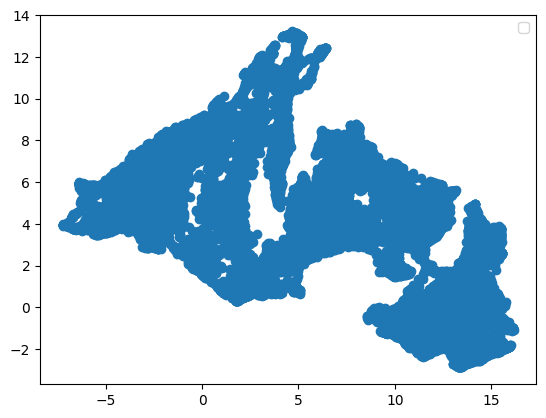

In [23]:
import matplotlib.pyplot as plt
scatter = plt.scatter(embedding[:,0], embedding[:,1])
plt.legend()

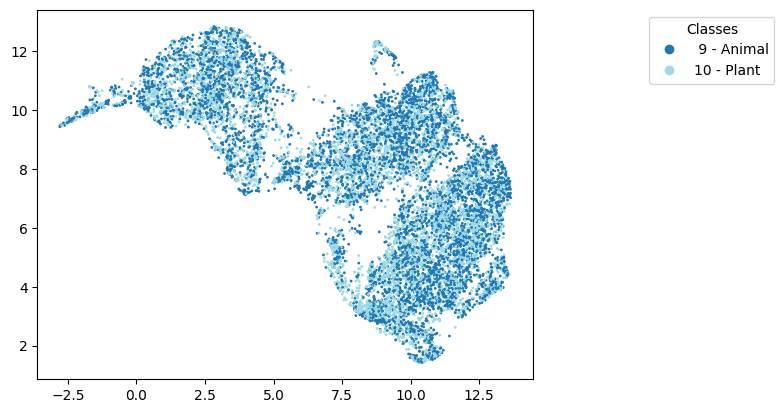

In [38]:
### plot the embedding
import matplotlib.pyplot as plt
scatter = plt.scatter(embedding[:, 0], embedding[:, 1],s =1,c = selected_subclasses, cmap='tab20')
legend = plt.legend(handles=scatter.legend_elements()[0], labels=used_subclass_names, title="Classes", loc='upper right', bbox_to_anchor=(1.5, 1))
plt.show()